In [10]:
DATA_PATH = "/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/dataset/FBD/WTI-log.csv"
PatchTST_PATH = "/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results/long_term_forecast_WTI-log_512_6_PatchTST_PatchTST_custom_ftMS_sl512_ll48_pl6_dm128_nh8_el2_dl1_df256_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/data_table.csv"
# 暂时放的是 DLinear 的结果，等跑完 PatchTST 再改
PatchTST_PATH = "/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results/long_term_forecast_WTI-log_HP_lr0.0001_DLinear_custom_ftMS_sl512_ll48_pl5_dm512_nh8_el2_dl1_df2048_expand2_dc4_fc1_ebtimeF_dtTrue_HP_LR_0/data_table.csv"
# 另一个PatchTST
PatchTST_PATH = "/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results_WTI_trading_20251128_042447/long_term_forecast_WTI-log_HP_dropout0.2_PatchTST_custom_ftMS_sl512_ll48_pl5_dm64_nh4_el2_dl1_df128_expand2_dc4_fc1_ebtimeF_dtTrue_HP_Dropout_0/data_table.csv"
# recommended TimeMixer model
TimeMixer_PATH = "/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results_WTI_trading_20251128_042447/long_term_forecast_WTI-log_512_6_TimeMixer_TimeMixer_custom_ftMS_sl512_ll0_pl6_dm16_nh8_el2_dl1_df32_expand2_dc4_fc1_ebtimeF_dtTrue_Exp_0/data_table.csv" # 离谱的结果
# Transformer, Nov 28 newest outcome
Transformer_PATH = "/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results_WTI_trading_extend_20251128_183138/long_term_forecast_WTI-log_Transformer_pl5_Transformer_custom_ftMS_sl512_ll48_pl5_dm64_nh4_el2_dl1_df128_expand2_dc4_fc1_ebtimeF_dtTrue_ModelComparison_1/data_table.csv"

In [11]:
# ============================================================
# Block 1: Setup and Data Loading
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

def load_data(raw_data_path, predictions_path):
    raw_df = pd.read_csv(raw_data_path, parse_dates=['date'])
    pred_df = pd.read_csv(predictions_path, parse_dates=['date'])
    
    print(f"Raw data shape: {raw_df.shape}")
    print(f"Predictions shape: {pred_df.shape}")
    print(f"\nRaw data columns: {raw_df.columns.tolist()}")
    print(f"Predictions columns: {pred_df.columns.tolist()}")
    
    return raw_df, pred_df

raw_df, pred_df = load_data(DATA_PATH, Transformer_PATH)

Raw data shape: (10685, 7)
Predictions shape: (2133, 11)

Raw data columns: ['date', 'open_future', 'high_future', 'low_future', 'volume_future', 'close_future', 'daily_return']
Predictions columns: ['date', 'true_0', 'true_1', 'true_2', 'true_3', 'true_4', 'pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4']


   horizon       MSE       MAE      RMSE        R2  Correlation  Corr_pvalue  \
0        0  0.000759  0.016481  0.027556 -0.011264     0.020373     0.346988   
1        1  0.000770  0.016663  0.027754 -0.025791     0.013018     0.547905   
2        2  0.000770  0.016666  0.027743 -0.024988     0.014255     0.510541   
3        3  0.000770  0.016664  0.027748 -0.025369     0.015034     0.487707   
4        4  0.000767  0.016607  0.027696 -0.021650     0.010722     0.620650   

      N  
0  2133  
1  2133  
2  2133  
3  2133  
4  2133  


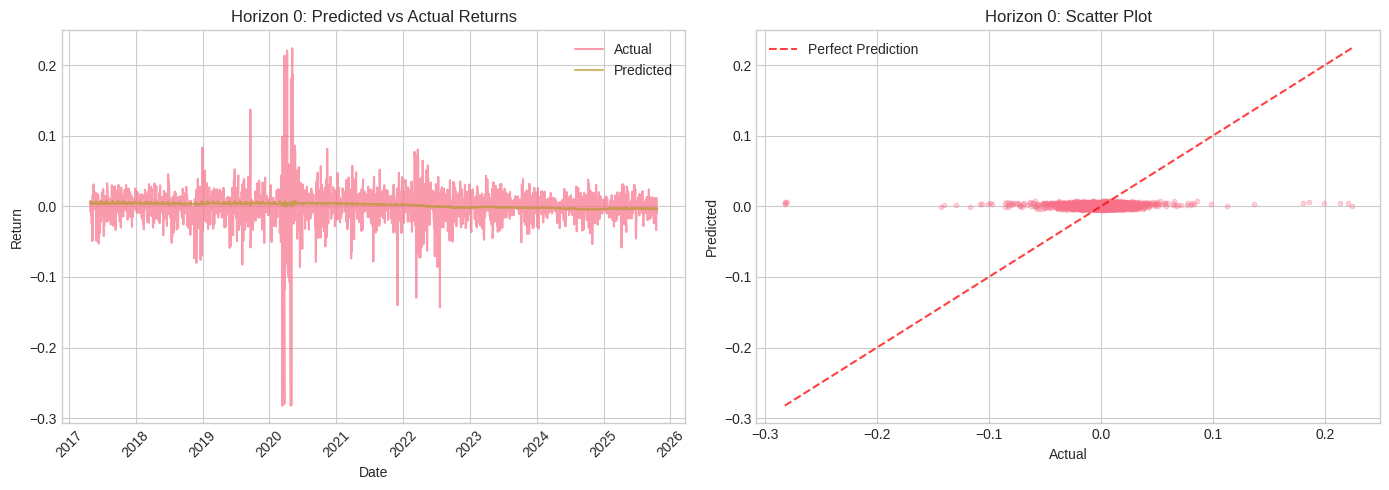

In [12]:
# ============================================================
# Block 2: Basic Prediction Performance Metrics
# ============================================================

def calculate_basic_metrics(pred_df, horizons=[0, 1, 2, 3, 4, 5]):
    """
    Calculate basic forecasting metrics: MSE, MAE, RMSE, R², correlation.
    """
    results = []
    
    for h in horizons:
        true_col = f'true_{h}'
        pred_col = f'pred_{h}'
        
        if true_col not in pred_df.columns or pred_col not in pred_df.columns:
            continue
            
        true_vals = pred_df[true_col].dropna()
        pred_vals = pred_df[pred_col].dropna()
        
        # Align indices
        common_idx = true_vals.index.intersection(pred_vals.index)
        true_vals = true_vals.loc[common_idx]
        pred_vals = pred_vals.loc[common_idx]
        
        # Calculate metrics
        mse = np.mean((true_vals - pred_vals) ** 2)
        mae = np.mean(np.abs(true_vals - pred_vals))
        rmse = np.sqrt(mse)
        
        # R-squared
        ss_res = np.sum((true_vals - pred_vals) ** 2)
        ss_tot = np.sum((true_vals - true_vals.mean()) ** 2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
        
        # Correlation
        corr, p_val = stats.pearsonr(true_vals, pred_vals)
        
        results.append({
            'horizon': h,
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'Correlation': corr,
            'Corr_pvalue': p_val,
            'N': len(true_vals)
        })
    
    return pd.DataFrame(results)

def plot_predictions_vs_actual(pred_df, horizon=0, figsize=(14, 5)):
    """
    Plot predicted vs actual values for a given horizon.
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    true_col = f'true_{horizon}'
    pred_col = f'pred_{horizon}'
    
    # Time series plot
    ax1 = axes[0]
    ax1.plot(pred_df['date'], pred_df[true_col], label='Actual', alpha=0.7)
    ax1.plot(pred_df['date'], pred_df[pred_col], label='Predicted', alpha=0.7)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Return')
    ax1.set_title(f'Horizon {horizon}: Predicted vs Actual Returns')
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)
    
    # Scatter plot
    ax2 = axes[1]
    ax2.scatter(pred_df[true_col], pred_df[pred_col], alpha=0.3, s=10)
    
    # Add 45-degree line
    lims = [
        min(pred_df[true_col].min(), pred_df[pred_col].min()),
        max(pred_df[true_col].max(), pred_df[pred_col].max())
    ]
    ax2.plot(lims, lims, 'r--', alpha=0.75, label='Perfect Prediction')
    ax2.set_xlabel('Actual')
    ax2.set_ylabel('Predicted')
    ax2.set_title(f'Horizon {horizon}: Scatter Plot')
    ax2.legend()
    
    plt.tight_layout()
    return fig

# Example usage:
metrics_df = calculate_basic_metrics(pred_df)
print(metrics_df)
fig = plot_predictions_vs_actual(pred_df, horizon=0)
plt.show()

### Mean-Reversion Analysis

In [13]:
# ============================================================
# Block 3: Mean-Reversion Analysis (Hypothesis 1.1)
# ============================================================

def test_mean_reversion_adf(series, name="Series"):
    """
    Augmented Dickey-Fuller test for stationarity (mean-reversion).
    H0: Unit root exists (non-stationary, no mean-reversion)
    H1: Stationary (mean-reverting)
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    output = {
        'name': name,
        'adf_statistic': result[0],
        'p_value': result[1],
        'lags_used': result[2],
        'n_obs': result[3],
        'critical_1%': result[4]['1%'],
        'critical_5%': result[4]['5%'],
        'critical_10%': result[4]['10%'],
        'is_mean_reverting': result[1] < 0.05
    }
    return output

def test_mean_reversion_hurst(series, max_lag=100):
    """
    Hurst Exponent estimation using R/S analysis.
    H < 0.5: Mean-reverting
    H = 0.5: Random walk
    H > 0.5: Trending/Momentum
    """
    series = series.dropna().values
    n = len(series)
    
    if n < max_lag:
        max_lag = n // 2
    
    lags = range(2, max_lag)
    rs_values = []
    
    for lag in lags:
        # Split series into chunks
        chunks = [series[i:i+lag] for i in range(0, n-lag, lag)]
        if len(chunks) == 0:
            continue
            
        rs_chunk = []
        for chunk in chunks:
            if len(chunk) < 2:
                continue
            mean_chunk = np.mean(chunk)
            cumdev = np.cumsum(chunk - mean_chunk)
            R = max(cumdev) - min(cumdev)
            S = np.std(chunk, ddof=1)
            if S > 0:
                rs_chunk.append(R / S)
        
        if len(rs_chunk) > 0:
            rs_values.append((lag, np.mean(rs_chunk)))
    
    if len(rs_values) < 2:
        return {'hurst_exponent': np.nan, 'interpretation': 'Insufficient data'}
    
    log_lags = np.log([x[0] for x in rs_values])
    log_rs = np.log([x[1] for x in rs_values])
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_lags, log_rs)
    
    if slope < 0.45:
        interpretation = "Mean-reverting"
    elif slope > 0.55:
        interpretation = "Trending/Momentum"
    else:
        interpretation = "Random walk"
    
    return {
        'hurst_exponent': slope,
        'r_squared': r_value**2,
        'p_value': p_value,
        'interpretation': interpretation
    }

def test_mean_reversion_variance_ratio(series, lags=[2, 4, 8, 16]):
    """
    Variance Ratio Test.
    VR = 1: Random walk
    VR < 1: Mean-reversion
    VR > 1: Momentum
    """
    series = series.dropna().values
    n = len(series)
    
    results = []
    var_1 = np.var(np.diff(series), ddof=1)
    
    for k in lags:
        if k >= n:
            continue
        var_k = np.var(series[k:] - series[:-k], ddof=1) / k
        vr = var_k / var_1 if var_1 > 0 else np.nan
        
        # Asymptotic standard error under H0: VR=1
        se = np.sqrt(2 * (2*k - 1) * (k - 1) / (3 * k * n))
        z_stat = (vr - 1) / se
        p_value = 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
        
        if vr < 0.9:
            interpretation = "Mean-reverting"
        elif vr > 1.1:
            interpretation = "Momentum"
        else:
            interpretation = "Random walk"
        
        results.append({
            'lag': k,
            'variance_ratio': vr,
            'z_statistic': z_stat,
            'p_value': p_value,
            'interpretation': interpretation
        })
    
    return pd.DataFrame(results)

def test_mean_reversion_halflife(series):
    """
    Estimate mean-reversion half-life using AR(1) model.
    Half-life = -log(2) / log(phi), where phi is AR(1) coefficient.
    """
    series = series.dropna()
    y = series.values[1:]
    x = series.values[:-1]
    
    # Regress y on x (AR(1))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    if slope >= 1 or slope <= 0:
        half_life = np.inf
    else:
        half_life = -np.log(2) / np.log(slope)
    
    return {
        'ar1_coefficient': slope,
        'half_life_periods': half_life,
        'r_squared': r_value**2,
        'p_value': p_value,
        'is_mean_reverting': slope < 1 and p_value < 0.05
    }

def comprehensive_mean_reversion_analysis(series, name="Series"):
    """
    Run all mean-reversion tests and compile results.
    """
    print(f"\n{'='*60}")
    print(f"Mean-Reversion Analysis: {name}")
    print('='*60)
    
    # ADF Test
    adf_result = test_mean_reversion_adf(series, name)
    print(f"\n1. ADF Test:")
    print(f"   Statistic: {adf_result['adf_statistic']:.4f}")
    print(f"   P-value: {adf_result['p_value']:.4f}")
    print(f"   Mean-reverting (p<0.05): {adf_result['is_mean_reverting']}")
    
    # Hurst Exponent
    hurst_result = test_mean_reversion_hurst(series)
    print(f"\n2. Hurst Exponent:")
    print(f"   H = {hurst_result['hurst_exponent']:.4f}")
    print(f"   Interpretation: {hurst_result['interpretation']}")
    
    # Variance Ratio
    vr_result = test_mean_reversion_variance_ratio(series)
    print(f"\n3. Variance Ratio Test:")
    print(vr_result.to_string(index=False))
    
    # Half-life
    hl_result = test_mean_reversion_halflife(series)
    print(f"\n4. AR(1) Half-Life:")
    print(f"   AR(1) coefficient: {hl_result['ar1_coefficient']:.4f}")
    print(f"   Half-life: {hl_result['half_life_periods']:.2f} periods")
    
    return {
        'adf': adf_result,
        'hurst': hurst_result,
        'variance_ratio': vr_result,
        'half_life': hl_result
    }

results = comprehensive_mean_reversion_analysis(raw_df['daily_return'], "WTI Daily Return")


Mean-Reversion Analysis: WTI Daily Return



1. ADF Test:
   Statistic: -18.5658
   P-value: 0.0000
   Mean-reverting (p<0.05): True

2. Hurst Exponent:
   H = 0.6225
   Interpretation: Trending/Momentum

3. Variance Ratio Test:
 lag  variance_ratio  z_statistic  p_value interpretation
   2        0.510251   -50.624516      0.0 Mean-reverting
   4        0.234981   -42.269352      0.0 Mean-reverting
   8        0.122530   -30.663074      0.0 Mean-reverting
  16        0.059222   -22.092949      0.0 Mean-reverting

4. AR(1) Half-Life:
   AR(1) coefficient: -0.0216
   Half-life: inf periods


### Momentum Analysis

   lag      beta     alpha  t_statistic   p_value  r_squared  \
0    1 -0.021553  0.000058    -2.228122  0.025893   0.000465   
1    5 -0.038809  0.000057    -4.013301  0.000060   0.001506   
2   10 -0.004158  0.000054    -0.429554  0.667529   0.000017   
3   20  0.018764  0.000052     1.937574  0.052702   0.000352   

                          interpretation  
0  Mean-reversion (significant negative)  
1  Mean-reversion (significant negative)  
2                 No significant pattern  
3                 No significant pattern  


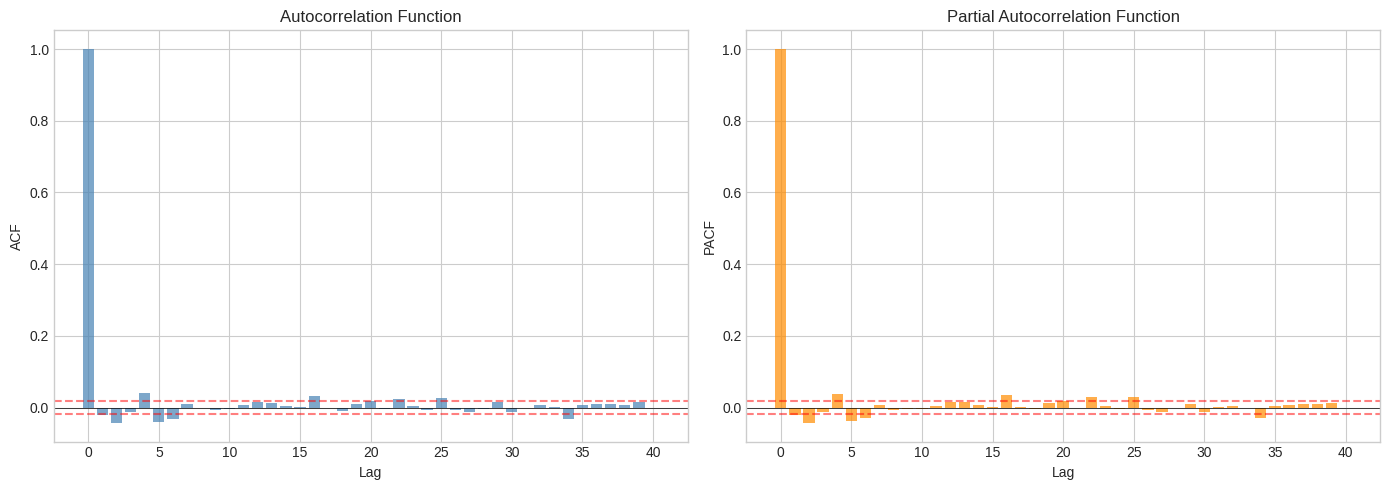

In [14]:
# ============================================================
# Block 4: Momentum Analysis (Hypothesis 1.1)
# ============================================================

def calculate_momentum_indicators(df, price_col='close_future', return_col='daily_return'):
    """
    Calculate various momentum indicators.
    """
    result = df.copy()
    
    # Simple momentum (rate of change)
    for period in [5, 10, 20, 60]:
        result[f'momentum_{period}'] = df[return_col].rolling(period).sum()
    
    # RSI (Relative Strength Index)
    delta = df[price_col].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    for period in [14, 28]:
        avg_gain = gain.rolling(period).mean()
        avg_loss = loss.rolling(period).mean()
        rs = avg_gain / avg_loss
        result[f'RSI_{period}'] = 100 - (100 / (1 + rs))
    
    # MACD
    ema_12 = df[price_col].ewm(span=12, adjust=False).mean()
    ema_26 = df[price_col].ewm(span=26, adjust=False).mean()
    result['MACD'] = ema_12 - ema_26
    result['MACD_signal'] = result['MACD'].ewm(span=9, adjust=False).mean()
    
    return result

def momentum_predictability_test(returns, lags=[1, 5, 10, 20]):
    """
    Test if past returns predict future returns (momentum).
    Uses lagged regression: r_t = alpha + beta * r_{t-lag} + epsilon
    """
    results = []
    returns = returns.dropna()
    
    for lag in lags:
        y = returns.iloc[lag:].values
        x = returns.iloc[:-lag].values
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        
        if slope > 0 and p_value < 0.05:
            interpretation = "Momentum (significant positive)"
        elif slope < 0 and p_value < 0.05:
            interpretation = "Mean-reversion (significant negative)"
        else:
            interpretation = "No significant pattern"
        
        results.append({
            'lag': lag,
            'beta': slope,
            'alpha': intercept,
            't_statistic': slope / std_err,
            'p_value': p_value,
            'r_squared': r_value**2,
            'interpretation': interpretation
        })
    
    return pd.DataFrame(results)

def autocorrelation_analysis(series, max_lags=40):
    """
    Compute and plot autocorrelation and partial autocorrelation.
    """
    series = series.dropna()
    
    acf_vals = acf(series, nlags=max_lags)
    pacf_vals = pacf(series, nlags=max_lags)
    
    # Ljung-Box test for serial correlation
    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb_result = acorr_ljungbox(series, lags=[10, 20, 40], return_df=True)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # ACF plot
    ax1 = axes[0]
    ax1.bar(range(len(acf_vals)), acf_vals, color='steelblue', alpha=0.7)
    ax1.axhline(y=0, color='black', linewidth=0.5)
    ax1.axhline(y=1.96/np.sqrt(len(series)), color='red', linestyle='--', alpha=0.5)
    ax1.axhline(y=-1.96/np.sqrt(len(series)), color='red', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('ACF')
    ax1.set_title('Autocorrelation Function')
    
    # PACF plot
    ax2 = axes[1]
    ax2.bar(range(len(pacf_vals)), pacf_vals, color='darkorange', alpha=0.7)
    ax2.axhline(y=0, color='black', linewidth=0.5)
    ax2.axhline(y=1.96/np.sqrt(len(series)), color='red', linestyle='--', alpha=0.5)
    ax2.axhline(y=-1.96/np.sqrt(len(series)), color='red', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Lag')
    ax2.set_ylabel('PACF')
    ax2.set_title('Partial Autocorrelation Function')
    
    plt.tight_layout()
    
    return {
        'acf': acf_vals,
        'pacf': pacf_vals,
        'ljung_box': lb_result,
        'figure': fig
    }

def compare_prediction_momentum_meanrev(pred_df, true_col='true_0', pred_col='pred_0'):
    """
    Analyze if model predictions show momentum or mean-reversion patterns.
    """
    pred_df = pred_df.dropna(subset=[true_col, pred_col])
    
    # Calculate prediction errors
    errors = pred_df[pred_col] - pred_df[true_col]
    
    # Test if errors are autocorrelated (model might be learning momentum/mean-rev)
    error_autocorr = autocorrelation_analysis(errors)
    
    # Compare lagged actual returns with predictions
    lagged_returns = pred_df[true_col].shift(1)
    
    # Does the model predict continuation (momentum) or reversal (mean-rev)?
    valid_idx = lagged_returns.notna()
    correlation = stats.pearsonr(lagged_returns[valid_idx], pred_df[pred_col][valid_idx])
    
    print(f"Correlation between lagged returns and predictions: {correlation[0]:.4f} (p={correlation[1]:.4f})")
    
    if correlation[0] > 0 and correlation[1] < 0.05:
        print("-> Model appears to learn MOMENTUM patterns")
    elif correlation[0] < 0 and correlation[1] < 0.05:
        print("-> Model appears to learn MEAN-REVERSION patterns")
    else:
        print("-> No significant momentum/mean-reversion pattern in predictions")
    
    return {
        'error_autocorr': error_autocorr,
        'lagged_correlation': correlation
    }

momentum_df = calculate_momentum_indicators(raw_df)
momentum_test = momentum_predictability_test(raw_df['daily_return'])
print(momentum_test)
acf_result = autocorrelation_analysis(raw_df['daily_return'])

### Seasonality Analysis

Using period: 252
Day-of-Week Effect ANOVA: F=1.5496, p=0.1849


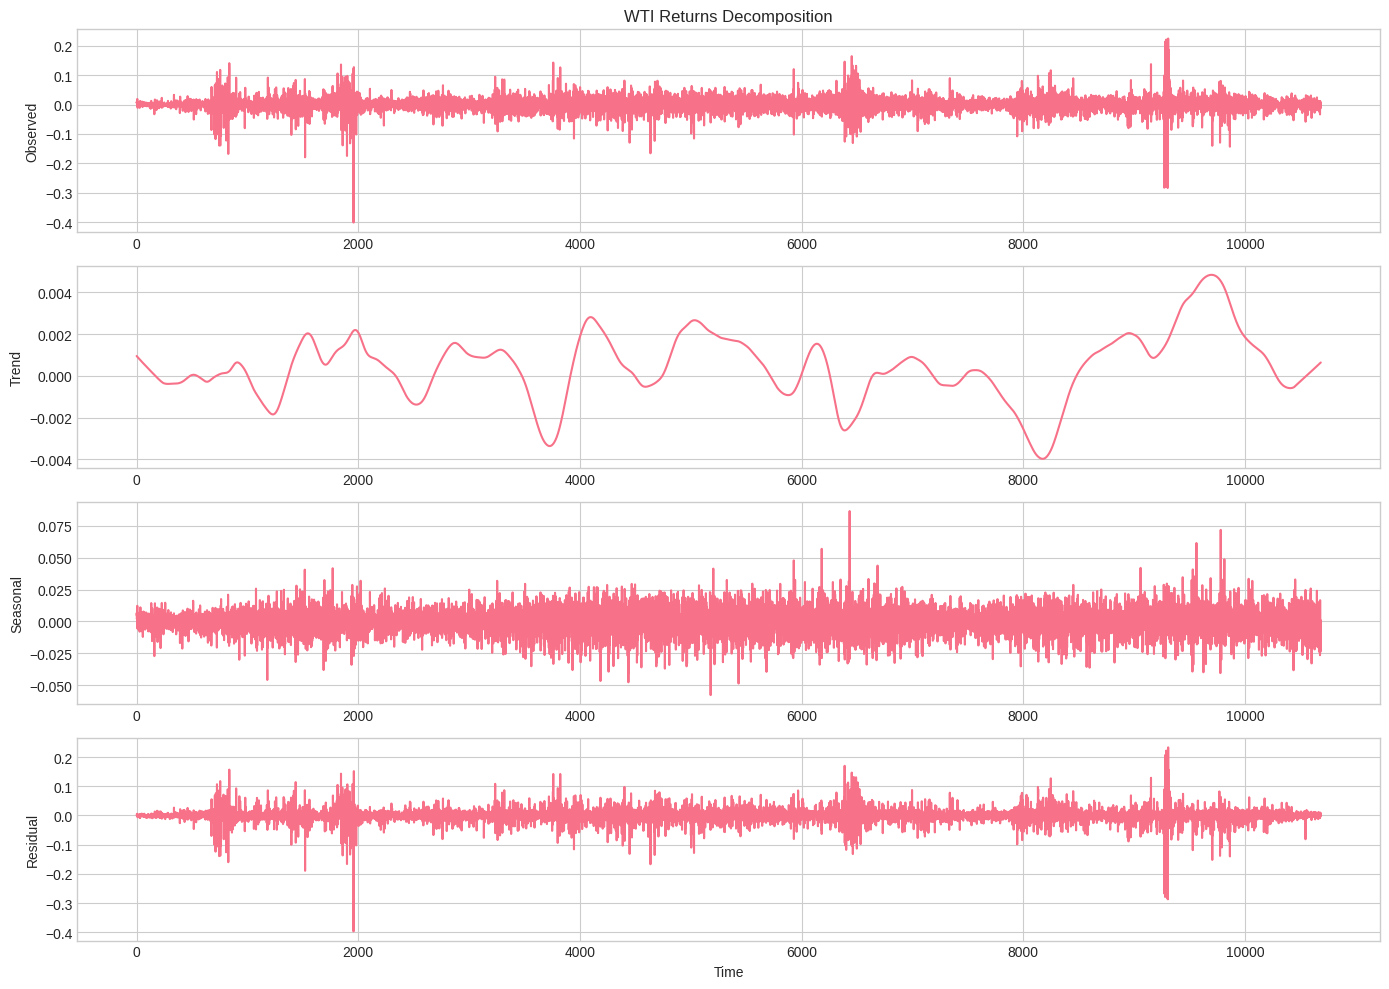

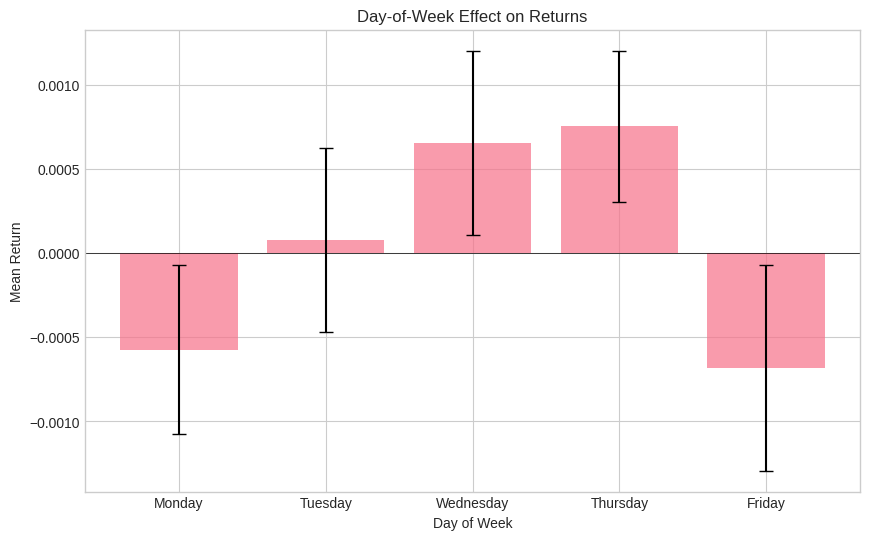

In [15]:
# ============================================================
# Block 5: Seasonality Analysis (Hypothesis 1.2)
# ============================================================

def decompose_time_series(series, period=None, model='additive'):
    """
    Decompose time series into trend, seasonal, and residual components.
    """
    series = series.dropna()
    
    if period is None:
        # Auto-detect period using FFT
        from scipy.fft import fft
        n = len(series)
        freqs = np.fft.fftfreq(n)
        fft_vals = np.abs(fft(series.values))
        
        # Find dominant frequency (excluding DC component)
        positive_freqs = freqs[1:n//2]
        positive_fft = fft_vals[1:n//2]
        dominant_freq = positive_freqs[np.argmax(positive_fft)]
        period = int(1 / dominant_freq) if dominant_freq > 0 else 252  # Default to yearly
        period = min(period, len(series) // 2)  # Ensure valid period
    
    print(f"Using period: {period}")
    
    # STL decomposition (more robust)
    stl = STL(series, period=period, robust=True)
    result = stl.fit()
    
    return result, period

def analyze_seasonality_strength(decomposition):
    """
    Quantify the strength of seasonality.
    Strength = 1 - Var(residual) / Var(detrended)
    """
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    trend = decomposition.trend
    
    detrended = decomposition.observed - trend
    
    # Seasonality strength
    var_residual = np.nanvar(residual)
    var_detrended = np.nanvar(detrended)
    
    seasonality_strength = max(0, 1 - var_residual / var_detrended) if var_detrended > 0 else 0
    
    # Trend strength
    var_seasonal_resid = np.nanvar(seasonal + residual)
    trend_strength = max(0, 1 - var_residual / var_seasonal_resid) if var_seasonal_resid > 0 else 0
    
    return {
        'seasonality_strength': seasonality_strength,
        'trend_strength': trend_strength,
        'residual_variance': var_residual
    }

def plot_decomposition(decomposition, title="Time Series Decomposition"):
    """
    Plot the decomposition components.
    """
    fig, axes = plt.subplots(4, 1, figsize=(14, 10))
    
    axes[0].plot(decomposition.observed)
    axes[0].set_ylabel('Observed')
    axes[0].set_title(title)
    
    axes[1].plot(decomposition.trend)
    axes[1].set_ylabel('Trend')
    
    axes[2].plot(decomposition.seasonal)
    axes[2].set_ylabel('Seasonal')
    
    axes[3].plot(decomposition.resid)
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Time')
    
    plt.tight_layout()
    return fig

def day_of_week_analysis(df, return_col='daily_return', date_col='date'):
    """
    Analyze day-of-week effects in returns.
    """
    df = df.copy()
    df['day_of_week'] = pd.to_datetime(df[date_col]).dt.dayofweek
    df['day_name'] = pd.to_datetime(df[date_col]).dt.day_name()
    
    # Group by day
    daily_stats = df.groupby('day_name')[return_col].agg(['mean', 'std', 'count'])
    daily_stats['t_stat'] = daily_stats['mean'] / (daily_stats['std'] / np.sqrt(daily_stats['count']))
    daily_stats['p_value'] = 2 * (1 - stats.t.cdf(np.abs(daily_stats['t_stat']), daily_stats['count'] - 1))
    
    # ANOVA test
    groups = [group[return_col].dropna().values for name, group in df.groupby('day_of_week')]
    f_stat, anova_p = stats.f_oneway(*groups)
    
    print(f"Day-of-Week Effect ANOVA: F={f_stat:.4f}, p={anova_p:.4f}")
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    daily_stats = daily_stats.reindex(order)
    
    ax.bar(daily_stats.index, daily_stats['mean'], yerr=daily_stats['std']/np.sqrt(daily_stats['count']),
           capsize=5, alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Day of Week')
    ax.set_ylabel('Mean Return')
    ax.set_title('Day-of-Week Effect on Returns')
    
    return daily_stats, (f_stat, anova_p), fig

def month_of_year_analysis(df, return_col='daily_return', date_col='date'):
    """
    Analyze month-of-year effects in returns.
    """
    df = df.copy()
    df['month'] = pd.to_datetime(df[date_col]).dt.month
    df['month_name'] = pd.to_datetime(df[date_col]).dt.month_name()
    
    # Group by month
    monthly_stats = df.groupby('month')[return_col].agg(['mean', 'std', 'count'])
    monthly_stats['t_stat'] = monthly_stats['mean'] / (monthly_stats['std'] / np.sqrt(monthly_stats['count']))
    
    # ANOVA test
    groups = [group[return_col].dropna().values for name, group in df.groupby('month')]
    f_stat, anova_p = stats.f_oneway(*groups)
    
    print(f"Month-of-Year Effect ANOVA: F={f_stat:.4f}, p={anova_p:.4f}")
    
    return monthly_stats, (f_stat, anova_p)

def compare_seasonal_vs_trend_assets(results_dict):
    """
    Compare analysis results across multiple assets to identify
    if transformers learn similar patterns regardless of seasonality.
    
    Parameters:
    -----------
    results_dict : dict
        Dictionary with asset names as keys and their analysis results as values.
    """
    comparison = []
    
    for asset, results in results_dict.items():
        row = {
            'asset': asset,
            'seasonality_strength': results.get('seasonality_strength', np.nan),
            'trend_strength': results.get('trend_strength', np.nan),
            'hurst_exponent': results.get('hurst', {}).get('hurst_exponent', np.nan),
            'ar1_coefficient': results.get('half_life', {}).get('ar1_coefficient', np.nan),
        }
        comparison.append(row)
    
    return pd.DataFrame(comparison)

decomp, period = decompose_time_series(raw_df['daily_return'], period=252)
strength = analyze_seasonality_strength(decomp)
fig = plot_decomposition(decomp, "WTI Returns Decomposition")
dow_stats, dow_anova, dow_fig = day_of_week_analysis(raw_df)

### Directional Accuracy and Confusion Matrix 

   horizon  directional_accuracy  n_correct  n_total   p_value  \
0        0              0.533521       1138     2133  0.001050   
1        1              0.535396       1142     2133  0.000579   
2        2              0.534927       1141     2133  0.000674   
3        3              0.534927       1141     2133  0.000674   
4        4              0.533052       1137     2133  0.001214   

   significant_at_5%  
0               True  
1               True  
2               True  
3               True  
4               True  


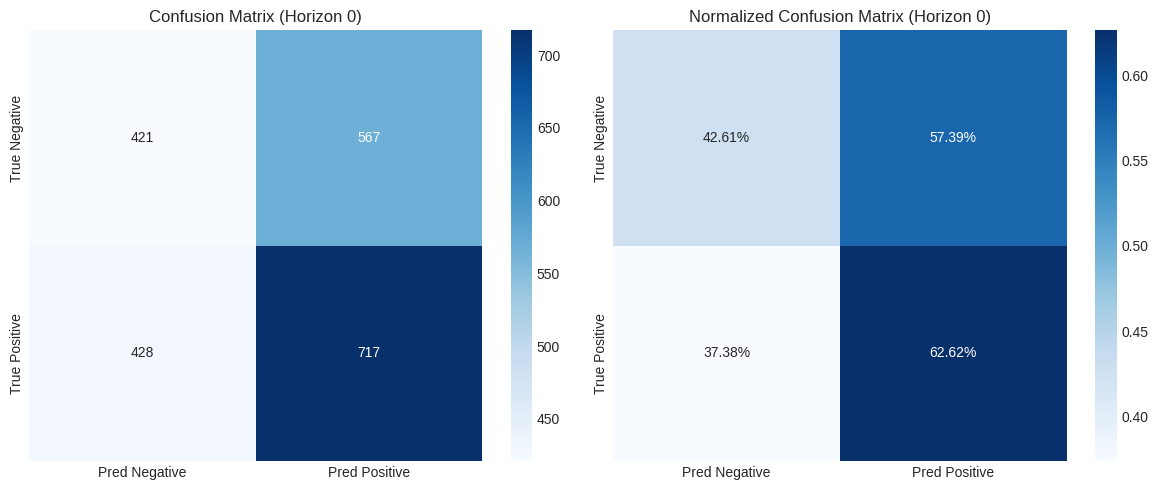

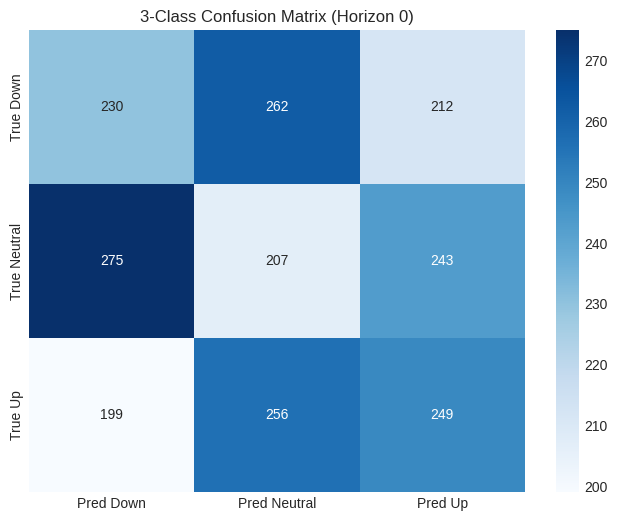

In [16]:
# ============================================================
# Block 6: Directional Accuracy and Confusion Matrices (Hypothesis 2)
# ============================================================

def calculate_directional_accuracy(pred_df, horizons=[0, 1, 2, 3, 4, 5]):
    """
    Calculate directional accuracy: how often the model predicts the correct sign.
    """
    results = []
    
    for h in horizons:
        true_col = f'true_{h}'
        pred_col = f'pred_{h}'
        
        if true_col not in pred_df.columns or pred_col not in pred_df.columns:
            continue
        
        valid_mask = pred_df[true_col].notna() & pred_df[pred_col].notna()
        true_sign = np.sign(pred_df.loc[valid_mask, true_col])
        pred_sign = np.sign(pred_df.loc[valid_mask, pred_col])
        
        # Remove zeros
        nonzero_mask = (true_sign != 0) & (pred_sign != 0)
        true_sign = true_sign[nonzero_mask]
        pred_sign = pred_sign[nonzero_mask]
        
        accuracy = (true_sign == pred_sign).mean()
        
        # Binomial test: is this better than random (50%)?
        n_correct = (true_sign == pred_sign).sum()
        n_total = len(true_sign)
        p_value = stats.binomtest(n_correct, n_total, 0.5, alternative='greater').pvalue
        
        results.append({
            'horizon': h,
            'directional_accuracy': accuracy,
            'n_correct': n_correct,
            'n_total': n_total,
            'p_value': p_value,
            'significant_at_5%': p_value < 0.05
        })
    
    return pd.DataFrame(results)

def create_confusion_matrix_analysis(pred_df, horizon=0, threshold=0):
    """
    Create and analyze confusion matrix for directional predictions.
    
    Parameters:
    -----------
    threshold : float
        Threshold for classifying as positive/negative. Default 0.
        Can also use percentile-based thresholds.
    """
    true_col = f'true_{horizon}'
    pred_col = f'pred_{horizon}'
    
    valid_mask = pred_df[true_col].notna() & pred_df[pred_col].notna()
    df = pred_df[valid_mask].copy()
    
    # Binary classification: positive vs negative returns
    true_class = (df[true_col] > threshold).astype(int)
    pred_class = (df[pred_col] > threshold).astype(int)
    
    # Confusion matrix
    cm = confusion_matrix(true_class, pred_class)
    
    # Classification report
    report = classification_report(true_class, pred_class, 
                                   target_names=['Negative', 'Positive'],
                                   output_dict=True)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Confusion matrix heatmap
    ax1 = axes[0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'])
    ax1.set_title(f'Confusion Matrix (Horizon {horizon})')
    
    # Normalized confusion matrix
    ax2 = axes[1]
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax2,
                xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'])
    ax2.set_title(f'Normalized Confusion Matrix (Horizon {horizon})')
    
    plt.tight_layout()
    
    return {
        'confusion_matrix': cm,
        'classification_report': report,
        'accuracy': accuracy_score(true_class, pred_class),
        'figure': fig
    }

def three_class_confusion_matrix(pred_df, horizon=0, percentile_threshold=33):
    """
    Create 3-class confusion matrix: Down, Neutral, Up
    """
    true_col = f'true_{horizon}'
    pred_col = f'pred_{horizon}'
    
    valid_mask = pred_df[true_col].notna() & pred_df[pred_col].notna()
    df = pred_df[valid_mask].copy()
    
    # Define thresholds using percentiles
    low_thresh_true = np.percentile(df[true_col], percentile_threshold)
    high_thresh_true = np.percentile(df[true_col], 100 - percentile_threshold)
    
    low_thresh_pred = np.percentile(df[pred_col], percentile_threshold)
    high_thresh_pred = np.percentile(df[pred_col], 100 - percentile_threshold)
    
    # Classify
    def classify(x, low, high):
        if x < low:
            return 0  # Down
        elif x > high:
            return 2  # Up
        else:
            return 1  # Neutral
    
    true_class = df[true_col].apply(lambda x: classify(x, low_thresh_true, high_thresh_true))
    pred_class = df[pred_col].apply(lambda x: classify(x, low_thresh_pred, high_thresh_pred))
    
    cm = confusion_matrix(true_class, pred_class)
    
    labels = ['Down', 'Neutral', 'Up']
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=[f'Pred {l}' for l in labels],
                yticklabels=[f'True {l}' for l in labels])
    ax.set_title(f'3-Class Confusion Matrix (Horizon {horizon})')
    
    return {
        'confusion_matrix': cm,
        'accuracy': accuracy_score(true_class, pred_class),
        'thresholds': {
            'true': (low_thresh_true, high_thresh_true),
            'pred': (low_thresh_pred, high_thresh_pred)
        },
        'figure': fig
    }

dir_acc = calculate_directional_accuracy(pred_df)
print(dir_acc)
cm_result = create_confusion_matrix_analysis(pred_df, horizon=0)
three_class_result = three_class_confusion_matrix(pred_df, horizon=0)

### Volatility Analysis

In [17]:
# ============================================================
# Block 7: Volatility Analysis (Hypothesis 2)
# ============================================================

def calculate_volatility_metrics(df, return_col='daily_return', windows=[5, 10, 20, 60]):
    """
    Calculate various volatility measures.
    """
    result = df.copy()
    
    # Rolling standard deviation (realized volatility)
    for w in windows:
        result[f'volatility_{w}d'] = result[return_col].rolling(w).std() * np.sqrt(252)
    
    # Parkinson volatility (using high/low)
    if 'high_future' in df.columns and 'low_future' in df.columns:
        result['parkinson_vol'] = np.sqrt(
            (1 / (4 * np.log(2))) * 
            (np.log(df['high_future'] / df['low_future']) ** 2)
        ).rolling(20).mean() * np.sqrt(252)
    
    # Garman-Klass volatility
    if all(col in df.columns for col in ['open_future', 'high_future', 'low_future', 'close_future']):
        log_hl = np.log(df['high_future'] / df['low_future'])
        log_co = np.log(df['close_future'] / df['open_future'])
        result['garman_klass_vol'] = np.sqrt(
            0.5 * log_hl**2 - (2*np.log(2) - 1) * log_co**2
        ).rolling(20).mean() * np.sqrt(252)
    
    return result

def analyze_volatility_regimes(df, return_col='daily_return', vol_col='volatility_20d', n_regimes=2):
    """
    Identify volatility regimes using simple threshold-based approach.
    """
    df = df.copy()
    
    if vol_col not in df.columns:
        df[vol_col] = df[return_col].rolling(20).std() * np.sqrt(252)
    
    # Simple regime classification using median
    median_vol = df[vol_col].median()
    df['vol_regime'] = np.where(df[vol_col] > median_vol, 'High Vol', 'Low Vol')
    
    # Analyze returns in each regime
    regime_stats = df.groupby('vol_regime')[return_col].agg(['mean', 'std', 'count'])
    
    return df, regime_stats

def prediction_accuracy_by_volatility(pred_df, vol_df, horizon=0):
    """
    Analyze if model accuracy varies with volatility regime.
    """
    true_col = f'true_{horizon}'
    pred_col = f'pred_{horizon}'
    
    # Merge predictions with volatility
    merged = pred_df.merge(vol_df[['date', 'vol_regime']], on='date', how='inner')
    
    results = []
    for regime in merged['vol_regime'].unique():
        regime_data = merged[merged['vol_regime'] == regime]
        
        valid_mask = regime_data[true_col].notna() & regime_data[pred_col].notna()
        regime_data = regime_data[valid_mask]
        
        # MSE
        mse = np.mean((regime_data[true_col] - regime_data[pred_col])**2)
        
        # Directional accuracy
        true_sign = np.sign(regime_data[true_col])
        pred_sign = np.sign(regime_data[pred_col])
        dir_acc = (true_sign == pred_sign).mean()
        
        # Correlation
        corr, _ = stats.pearsonr(regime_data[true_col], regime_data[pred_col])
        
        results.append({
            'regime': regime,
            'n_obs': len(regime_data),
            'mse': mse,
            'directional_accuracy': dir_acc,
            'correlation': corr
        })
    
    return pd.DataFrame(results)

def garch_analysis(returns, p=1, q=1):
    """
    Fit GARCH model for volatility analysis.
    Requires: pip install arch
    """
    try:
        from arch import arch_model
    except ImportError:
        print("Please install arch package: pip install arch")
        return None
    
    returns = returns.dropna() * 100  # Convert to percentage for numerical stability
    
    # Fit GARCH model
    model = arch_model(returns, vol='Garch', p=p, q=q, dist='normal')
    result = model.fit(disp='off')
    
    print(result.summary())
    
    # Extract conditional volatility
    cond_vol = result.conditional_volatility
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    axes[0].plot(returns.index, returns, alpha=0.7)
    axes[0].set_ylabel('Returns (%)')
    axes[0].set_title('Returns')
    
    axes[1].plot(cond_vol.index, cond_vol, color='red', alpha=0.7)
    axes[1].set_ylabel('Conditional Volatility (%)')
    axes[1].set_title('GARCH Conditional Volatility')
    
    plt.tight_layout()
    
    return result, cond_vol, fig

vol_df = calculate_volatility_metrics(raw_df)
vol_df, regime_stats = analyze_volatility_regimes(vol_df)
print(regime_stats)
vol_accuracy = prediction_accuracy_by_volatility(pred_df, vol_df, horizon=0)
print(vol_accuracy)

                mean       std  count
vol_regime                           
High Vol    0.000213  0.032148   5333
Low Vol    -0.000097  0.013692   5352
     regime  n_obs       mse  directional_accuracy  correlation
0   Low Vol   1285  0.000209              0.536187     0.059486
1  High Vol    848  0.001593              0.529481     0.013701


### Sharpe Ratio Analysis

buyhold_total_return       -0.486828
buyhold_sharpe              0.044286
strategy_total_return       1.225798
strategy_sharpe             0.441492
strategy_tc_total_return    1.125939
strategy_tc_sharpe          0.429129
max_drawdown               -0.864874
win_rate                    0.533521
profit_factor               1.097150
dtype: float64


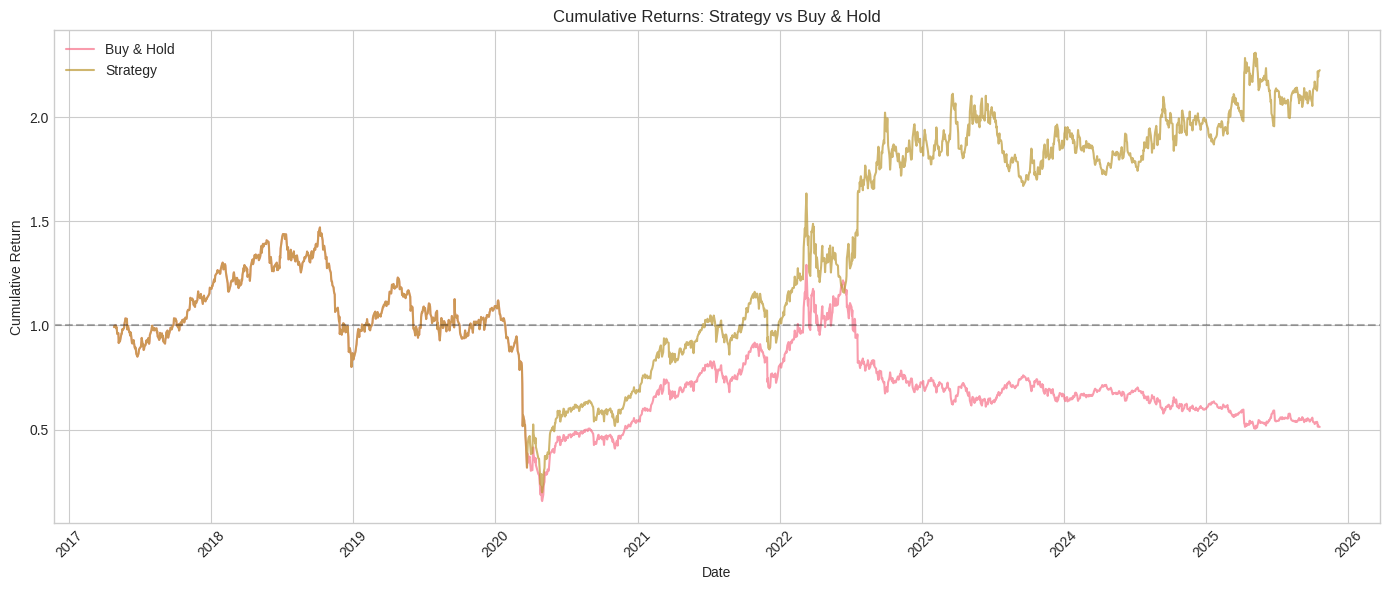

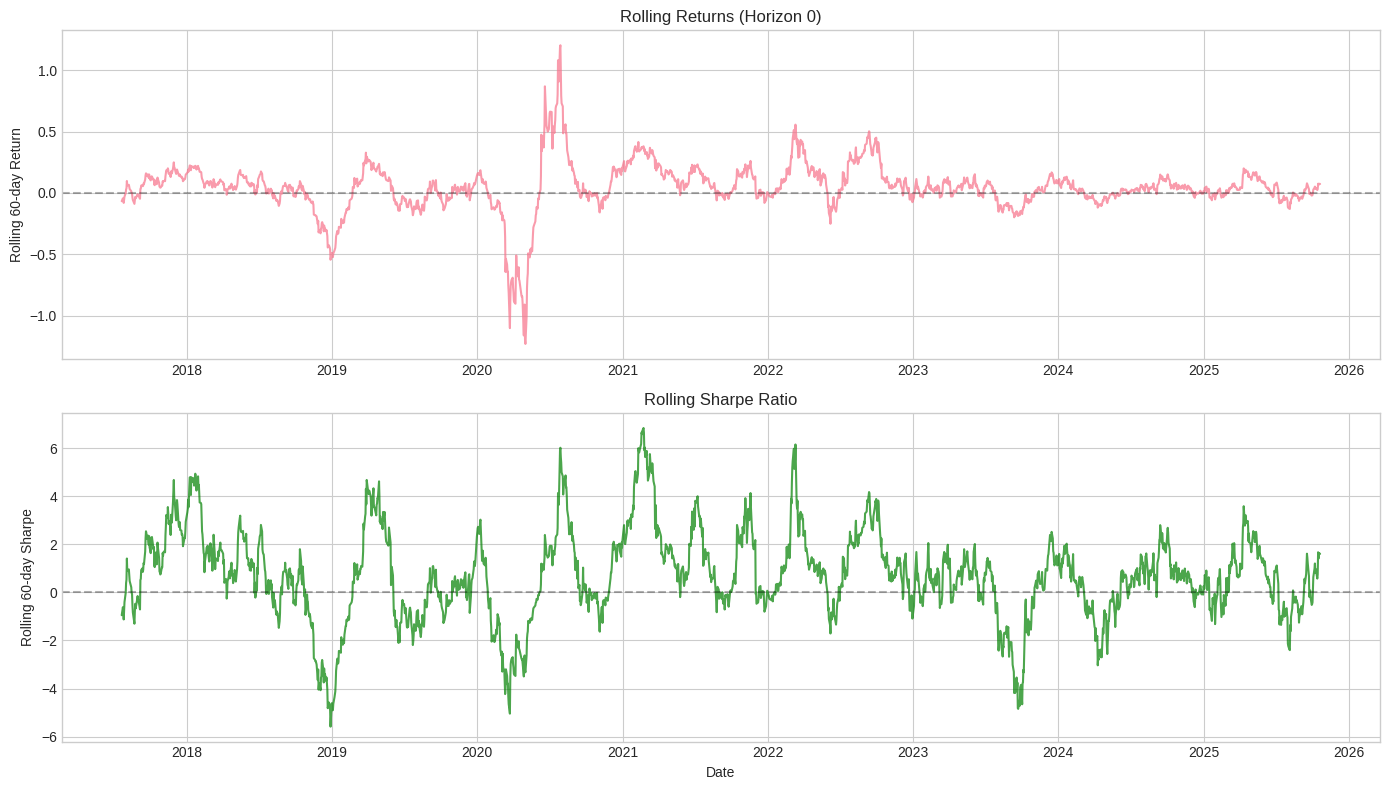

In [18]:
# ============================================================
# Block 8: Sharpe Ratio and Risk-Adjusted Performance (Hypothesis 2)
# ============================================================

def calculate_sharpe_ratio(returns, risk_free_rate=0.0, annualize=True):
    """
    Calculate Sharpe ratio.
    
    Parameters:
    -----------
    returns : pd.Series
        Daily returns
    risk_free_rate : float
        Annual risk-free rate (default 0)
    annualize : bool
        Whether to annualize the Sharpe ratio
    """
    excess_returns = returns - risk_free_rate / 252
    
    mean_excess = excess_returns.mean()
    std_excess = excess_returns.std()
    
    sharpe = mean_excess / std_excess if std_excess > 0 else 0
    
    if annualize:
        sharpe *= np.sqrt(252)
    
    return sharpe

def calculate_strategy_metrics(pred_df, horizon=0, transaction_cost=0.001):
    """
    Calculate strategy performance metrics assuming we trade based on predictions.
    
    Strategy: Go long if pred > 0, short if pred < 0
    """
    true_col = f'true_{horizon}'
    pred_col = f'pred_{horizon}'
    
    df = pred_df.dropna(subset=[true_col, pred_col]).copy()
    
    # Signal: +1 for long, -1 for short
    df['signal'] = np.sign(df[pred_col])
    
    # Strategy returns (before transaction costs)
    df['strategy_return'] = df['signal'] * df[true_col]
    
    # Add transaction costs when signal changes
    df['signal_change'] = df['signal'].diff().abs()
    df['strategy_return_tc'] = df['strategy_return'] - df['signal_change'] * transaction_cost
    
    # Calculate metrics
    metrics = {}
    
    # Buy and Hold
    metrics['buyhold_total_return'] = (1 + df[true_col]).prod() - 1
    metrics['buyhold_sharpe'] = calculate_sharpe_ratio(df[true_col])
    
    # Strategy (no TC)
    metrics['strategy_total_return'] = (1 + df['strategy_return']).prod() - 1
    metrics['strategy_sharpe'] = calculate_sharpe_ratio(df['strategy_return'])
    
    # Strategy (with TC)
    metrics['strategy_tc_total_return'] = (1 + df['strategy_return_tc']).prod() - 1
    metrics['strategy_tc_sharpe'] = calculate_sharpe_ratio(df['strategy_return_tc'])
    
    # Maximum drawdown
    cumulative = (1 + df['strategy_return']).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    metrics['max_drawdown'] = drawdown.min()
    
    # Win rate
    metrics['win_rate'] = (df['strategy_return'] > 0).mean()
    
    # Profit factor
    wins = df.loc[df['strategy_return'] > 0, 'strategy_return'].sum()
    losses = -df.loc[df['strategy_return'] < 0, 'strategy_return'].sum()
    metrics['profit_factor'] = wins / losses if losses > 0 else np.inf
    
    return metrics, df

def plot_cumulative_returns(df, true_col='true_0', strategy_col='strategy_return'):
    """
    Plot cumulative returns comparison.
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Cumulative returns
    cum_actual = (1 + df[true_col]).cumprod()
    cum_strategy = (1 + df[strategy_col]).cumprod()
    
    ax.plot(df['date'], cum_actual, label='Buy & Hold', alpha=0.7)
    ax.plot(df['date'], cum_strategy, label='Strategy', alpha=0.7)
    ax.axhline(y=1, color='black', linestyle='--', alpha=0.3)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.set_title('Cumulative Returns: Strategy vs Buy & Hold')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

def rolling_sharpe_analysis(pred_df, horizon=0, window=60):
    """
    Calculate rolling Sharpe ratios.
    """
    true_col = f'true_{horizon}'
    pred_col = f'pred_{horizon}'
    
    df = pred_df.dropna(subset=[true_col, pred_col]).copy()
    
    df['signal'] = np.sign(df[pred_col])
    df['strategy_return'] = df['signal'] * df[true_col]
    
    # Rolling Sharpe
    rolling_mean = df['strategy_return'].rolling(window).mean()
    rolling_std = df['strategy_return'].rolling(window).std()
    df['rolling_sharpe'] = (rolling_mean / rolling_std) * np.sqrt(252)
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    axes[0].plot(df['date'], df['strategy_return'].rolling(window).sum(), alpha=0.7)
    axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axes[0].set_ylabel(f'Rolling {window}-day Return')
    axes[0].set_title(f'Rolling Returns (Horizon {horizon})')
    
    axes[1].plot(df['date'], df['rolling_sharpe'], alpha=0.7, color='green')
    axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axes[1].set_ylabel(f'Rolling {window}-day Sharpe')
    axes[1].set_title(f'Rolling Sharpe Ratio')
    axes[1].set_xlabel('Date')
    
    plt.tight_layout()
    
    return df, fig

metrics, strategy_df = calculate_strategy_metrics(pred_df, horizon=0)
print(pd.Series(metrics))
fig = plot_cumulative_returns(strategy_df)
rolling_df, rolling_fig = rolling_sharpe_analysis(pred_df, horizon=0)

### Interpretation Guide for Each Analysis Component

In [19]:
# ============================================================
# Interpretation Guide for Each Analysis Component
# ============================================================

def print_interpretation_guide():
    """
    Print detailed interpretation guide for all analyses.
    """
    guide = """
╔══════════════════════════════════════════════════════════════════════════════╗
║                    INTERPRETATION GUIDE FOR TIME SERIES ANALYSIS              ║
╚══════════════════════════════════════════════════════════════════════════════╝

═══════════════════════════════════════════════════════════════════════════════
1. BASIC PREDICTION METRICS
═══════════════════════════════════════════════════════════════════════════════

┌─────────────────┬────────────────────────────────────────────────────────────┐
│ Metric          │ Interpretation                                             │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ MSE             │ Lower = Better. Sensitive to outliers.                     │
│                 │ Compare across horizons: increasing MSE suggests           │
│                 │ prediction difficulty grows with horizon.                  │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ MAE             │ Lower = Better. More robust to outliers than MSE.          │
│                 │ If MAE << MSE^0.5, you have outlier prediction errors.     │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ R²              │ Proportion of variance explained.                          │
│                 │ R² < 0: Model worse than predicting the mean.              │
│                 │ R² ~ 0: Model ≈ predicting the mean.                       │
│                 │ R² > 0.01 for returns is actually quite good!              │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Correlation     │ Linear relationship between pred and true.                 │
│                 │ For financial returns:                                     │
│                 │   > 0.10: Strong predictive signal                         │
│                 │   0.05-0.10: Moderate signal                               │
│                 │   < 0.05: Weak signal (but may still be tradeable)         │
└─────────────────┴────────────────────────────────────────────────────────────┘

⚠️  KEY INSIGHT: For financial returns, even small R² (1-2%) or correlations 
    (5-10%) can translate to profitable strategies because you're compounding
    small edges over many trades.


═══════════════════════════════════════════════════════════════════════════════
2. MEAN-REVERSION ANALYSIS
═══════════════════════════════════════════════════════════════════════════════

┌─────────────────┬────────────────────────────────────────────────────────────┐
│ Test            │ Interpretation                                             │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ ADF Test        │ Tests for unit root (non-stationarity).                    │
│                 │ p < 0.05: Reject H0 → Series is STATIONARY (mean-reverting)│
│                 │ p > 0.05: Cannot reject H0 → May have unit root            │
│                 │ For returns: usually p < 0.05 (returns are stationary)     │
│                 │ For prices: usually p > 0.05 (prices are non-stationary)   │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Hurst Exponent  │ Measures long-memory/persistence.                          │
│                 │ H < 0.5: MEAN-REVERTING (anti-persistent)                  │
│                 │ H = 0.5: RANDOM WALK (no memory)                           │
│                 │ H > 0.5: TRENDING/MOMENTUM (persistent)                    │
│                 │                                                            │
│                 │ Financial interpretation:                                  │
│                 │ H = 0.45-0.55: Essentially random (efficient market)       │
│                 │ H < 0.45: Strong mean-reversion opportunity                │
│                 │ H > 0.55: Momentum trading opportunity                     │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Variance Ratio  │ Tests random walk hypothesis.                              │
│                 │ VR = 1: Random walk                                        │
│                 │ VR < 1: MEAN-REVERTING (negative autocorrelation)          │
│                 │ VR > 1: MOMENTUM (positive autocorrelation)                │
│                 │                                                            │
│                 │ p < 0.05 indicates significant deviation from random walk. │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Half-Life      │ Time for deviation to revert halfway to mean.              │
│                 │ Short half-life (< 5 days): Fast mean-reversion            │
│                 │ Medium (5-20 days): Tradeable mean-reversion               │
│                 │ Long (> 20 days): Slow reversion, harder to trade          │
│                 │ Infinite: No mean-reversion                                │
└─────────────────┴────────────────────────────────────────────────────────────┘

⚠️  KEY INSIGHT FOR HYPOTHESIS 1.1:
    If your model shows positive correlation between predictions and lagged 
    returns → Model is learning MOMENTUM
    If negative correlation → Model is learning MEAN-REVERSION
    If no correlation → Model may be learning more complex patterns


═══════════════════════════════════════════════════════════════════════════════
3. MOMENTUM ANALYSIS
═══════════════════════════════════════════════════════════════════════════════

┌─────────────────┬────────────────────────────────────────────────────────────┐
│ Test            │ Interpretation                                             │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Lagged          │ r_t = α + β * r_{t-lag} + ε                                │
│ Regression      │                                                            │
│                 │ β > 0 (p < 0.05): MOMENTUM at that lag                     │
│                 │ β < 0 (p < 0.05): MEAN-REVERSION at that lag               │
│                 │ β ≈ 0 or p > 0.05: No predictable pattern                  │
│                 │                                                            │
│                 │ Check multiple lags to see pattern evolution:              │
│                 │ - Short lags (1-5): Microstructure effects                 │
│                 │ - Medium lags (5-20): Trading momentum                     │
│                 │ - Long lags (20-60): Factor momentum                       │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ ACF/PACF        │ Autocorrelation at various lags.                           │
│                 │                                                            │
│                 │ Significant positive ACF at lag k:                         │
│                 │   → Returns k periods ago predict today (momentum)         │
│                 │ Significant negative ACF at lag k:                         │
│                 │   → Reversal pattern at lag k                              │
│                 │                                                            │
│                 │ For efficient markets: ACF ≈ 0 for all lags                │
│                 │ Red dashed lines show 95% confidence bounds                │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Model Pattern   │ corr(pred_t, true_{t-1})                                   │
│ Detection       │                                                            │
│                 │ Strong positive: Model learned momentum                    │
│                 │ Strong negative: Model learned mean-reversion              │
│                 │ Near zero: Model learned something else (or nothing)       │
└─────────────────┴────────────────────────────────────────────────────────────┘


═══════════════════════════════════════════════════════════════════════════════
4. SEASONALITY ANALYSIS (Hypothesis 1.2)
═══════════════════════════════════════════════════════════════════════════════

┌─────────────────┬────────────────────────────────────────────────────────────┐
│ Metric          │ Interpretation                                             │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Seasonality     │ Proportion of variance explained by seasonal component.    │
│ Strength        │                                                            │
│                 │ > 0.6: Strong seasonality                                  │
│                 │ 0.3-0.6: Moderate seasonality                              │
│                 │ < 0.3: Weak seasonality                                    │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Trend           │ Proportion of variance explained by trend.                 │
│ Strength        │                                                            │
│                 │ Compare with seasonality strength to understand            │
│                 │ what drives the series.                                    │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Day-of-Week     │ ANOVA F-test and p-value.                                  │
│ Effect          │                                                            │
│                 │ p < 0.05: Significant day-of-week effect exists            │
│                 │ Common patterns: Monday effect, Friday effect              │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Month Effect    │ ANOVA F-test and p-value.                                  │
│                 │                                                            │
│                 │ p < 0.05: Significant monthly seasonality                  │
│                 │ Common: January effect, sell-in-May                        │
└─────────────────┴────────────────────────────────────────────────────────────┘

⚠️  KEY INSIGHT FOR HYPOTHESIS 1.2:
    Compare Oil, Gold, AAPL:
    - If model accuracy is similar despite different seasonality → 
      Model learns simple patterns (momentum/mean-rev), not seasonality
    - If model accuracy differs with seasonality → 
      Model may be capturing seasonal patterns


═══════════════════════════════════════════════════════════════════════════════
5. DIRECTIONAL ACCURACY & CONFUSION MATRIX (Hypothesis 2)
═══════════════════════════════════════════════════════════════════════════════

┌─────────────────┬────────────────────────────────────────────────────────────┐
│ Metric          │ Interpretation                                             │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Directional     │ % of times model predicts correct sign (up/down).          │
│ Accuracy        │                                                            │
│                 │ > 55%: Good (statistically significant edge)               │
│                 │ 52-55%: Moderate (may be tradeable with low costs)         │
│                 │ 50-52%: Weak (needs very low transaction costs)            │
│                 │ < 50%: Model is worse than random!                         │
│                 │                                                            │
│                 │ Use binomial test p-value to check if > 50% is real.       │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Confusion       │ ┌──────────────┬───────────────┬───────────────┐           │
│ Matrix          │ │              │ Pred Negative │ Pred Positive │           │
│                 │ ├──────────────┼───────────────┼───────────────┤           │
│                 │ │ True Negative│      TN       │      FP       │           │
│                 │ │ True Positive│      FN       │      TP       │           │
│                 │ └──────────────┴───────────────┴───────────────┘           │
│                 │                                                            │
│                 │ Accuracy = (TP + TN) / Total                               │
│                 │ Precision = TP / (TP + FP) - When we predict up, accuracy  │
│                 │ Recall = TP / (TP + FN) - Of all up days, how many caught  │
│                 │                                                            │
│                 │ For trading:                                               │
│                 │ High FP: Too many false buy signals (losses)               │
│                 │ High FN: Missing profitable opportunities                  │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ 3-Class         │ Down / Neutral / Up classification.                        │
│ Matrix          │                                                            │
│                 │ Check diagonal dominance: good model has high diagonal     │
│                 │ Off-diagonal patterns show systematic errors               │
└─────────────────┴────────────────────────────────────────────────────────────┘


═══════════════════════════════════════════════════════════════════════════════
6. SHARPE RATIO & RISK-ADJUSTED METRICS
═══════════════════════════════════════════════════════════════════════════════

┌─────────────────┬────────────────────────────────────────────────────────────┐
│ Metric          │ Interpretation                                             │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Sharpe Ratio    │ Risk-adjusted return: (Return - Rf) / Volatility           │
│                 │                                                            │
│                 │ Industry benchmarks (annual):                              │
│                 │ < 0: Losing money on risk-adjusted basis                   │
│                 │ 0-0.5: Poor                                                │
│                 │ 0.5-1.0: Acceptable                                        │
│                 │ 1.0-2.0: Good                                              │
│                 │ 2.0-3.0: Excellent                                         │
│                 │ > 3.0: Exceptional (verify no data issues!)                │
│                 │                                                            │
│                 │ ⚠️  Common pitfalls causing misleadingly low Sharpe:       │
│                 │ - Not annualizing (multiply by √252 for daily)             │
│                 │ - Including transaction costs incorrectly                  │
│                 │ - Survivorship bias in backtest                            │
│                 │ - Look-ahead bias in signal                                │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Sortino Ratio   │ Like Sharpe but uses only downside deviation.              │
│                 │ Better for asymmetric return distributions.                │
│                 │ Sortino > Sharpe suggests positive skew (good)             │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Max Drawdown    │ Largest peak-to-trough decline.                            │
│                 │                                                            │
│                 │ < 10%: Conservative strategy                               │
│                 │ 10-20%: Moderate risk                                      │
│                 │ 20-30%: Aggressive                                         │
│                 │ > 30%: High risk (may be unacceptable for many investors)  │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Win Rate        │ % of trades that are profitable.                           │
│                 │                                                            │
│                 │ Win rate alone is NOT enough! Must consider:               │
│                 │ - Average win size vs average loss size                    │
│                 │ - Profit factor = Total wins / Total losses                │
│                 │                                                            │
│                 │ A 40% win rate can be very profitable if:                  │
│                 │   Avg win >> Avg loss (trend following)                    │
│                 │ A 70% win rate can lose money if:                          │
│                 │   Avg loss >> Avg win (picking up pennies)                 │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Calmar Ratio    │ Annual Return / Max Drawdown.                              │
│                 │                                                            │
│                 │ > 1.0: Return exceeds worst drawdown (good)                │
│                 │ > 2.0: Excellent risk-adjusted performance                 │
└─────────────────┴────────────────────────────────────────────────────────────┘


═══════════════════════════════════════════════════════════════════════════════
7. VOLATILITY REGIME ANALYSIS
═══════════════════════════════════════════════════════════════════════════════

┌─────────────────┬────────────────────────────────────────────────────────────┐
│ Finding         │ Interpretation                                             │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Higher accuracy │ Model may be detecting volatility clustering.              │
│ in high vol     │ High volatility = larger price moves = easier to predict   │
│                 │ direction (but magnitude harder).                          │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Higher accuracy │ Model performs better when markets are calm.               │
│ in low vol      │ Could indicate model overfits to "normal" conditions.      │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ Similar across  │ Model is robust to volatility regime.                      │
│ regimes         │ Good sign for real-world deployment.                       │
└─────────────────┴────────────────────────────────────────────────────────────┘


═══════════════════════════════════════════════════════════════════════════════
8. MULTI-ASSET COMPARISON (Hypothesis 2: GSMI vs Single Asset)
═══════════════════════════════════════════════════════════════════════════════

Key questions to answer:
1. Does GSMI model outperform single-asset models?
   - Compare Sharpe ratios across assets
   - If GSMI Sharpe >> individual asset Sharpes:
     → Multi-asset signals provide additional information

2. What patterns does GSMI detect that single-asset misses?
   - Cross-sectional momentum (winners keep winning)
   - Mean-reversion across assets
   - Volatility spillovers

3. Consistency check:
   - If all assets show similar Hurst/momentum patterns but different accuracy:
     → Market microstructure or liquidity differences
   - If assets show different patterns and different accuracy:
     → Model adapts to asset characteristics


═══════════════════════════════════════════════════════════════════════════════
COMMON ISSUES AND DEBUGGING
═══════════════════════════════════════════════════════════════════════════════

❌ Problem: Sharpe ratio is 0 or very close to 0
   Possible causes:
   1. Model predicts nearly constant values (variance collapse)
   2. No actual predictive signal
   3. Bug in return calculation
   
   Debug: Check pred_df[pred_col].std() - should be similar to true_col

❌ Problem: Directional accuracy < 50%
   Possible causes:
   1. Sign of prediction is inverted
   2. Timing mismatch (true_0 is same-day instead of next-day)
   3. Model genuinely worse than random
   
   Debug: Run diagnose_prediction_alignment()

❌ Problem: Very high Sharpe (> 3) in backtest
   Possible causes:
   1. Look-ahead bias (using future information)
   2. Survivorship bias
   3. Not accounting for transaction costs
   4. Bug in return calculation
   
   Debug: Check alignment, verify no data leakage

❌ Problem: Hurst ≈ 0.5 but model shows momentum
   This is normal! Hurst measures the underlying series.
   Model predictions can still have momentum bias.
   Check corr(predictions, lagged_returns) instead.
"""
    print(guide)

# Run this to see the full interpretation guide:
print_interpretation_guide()


╔══════════════════════════════════════════════════════════════════════════════╗
║                    INTERPRETATION GUIDE FOR TIME SERIES ANALYSIS              ║
╚══════════════════════════════════════════════════════════════════════════════╝

═══════════════════════════════════════════════════════════════════════════════
1. BASIC PREDICTION METRICS
═══════════════════════════════════════════════════════════════════════════════

┌─────────────────┬────────────────────────────────────────────────────────────┐
│ Metric          │ Interpretation                                             │
├─────────────────┼────────────────────────────────────────────────────────────┤
│ MSE             │ Lower = Better. Sensitive to outliers.                     │
│                 │ Compare across horizons: increasing MSE suggests           │
│                 │ prediction difficulty grows with horizon.                  │
├─────────────────┼────────────────────────────────────────────────────────────